### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import root

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

#### Modelling data:

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]
N = 20        # number of modelling nodes

In [5]:
mi = [mp for i in range(N)]

In [6]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 84.6 # [m]
B = 12
H = 13
Xg = L/2 # [m]
mn = 27_162_500  # mass of the vessel, [kg]

In [7]:
lx, ly, lz = L/2, B/2, H/2

In [8]:
vessel_mass = mn/L # mass over length of the vessel

In [9]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [10]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [11]:
Ar=np.pi*((d0/2)**2-(dI/2)**2)   

In [12]:
E = 210e9

In [13]:
h = 100 # water depth

In [14]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [15]:
# Constants: 

In [16]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [17]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [18]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [19]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [20]:
# for testing:

In [21]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [22]:
φ

array([0.74178704, 0.89054652, 0.3950693 , 0.50913975, 0.57051938,
       0.31516564, 0.44064428, 0.0219581 , 0.08349766, 0.23834259,
       0.04352741, 0.71495702, 0.50349973, 0.83154564, 0.6680603 ,
       0.24611886, 0.30502693, 0.34631509, 0.56592801, 0.57103082])

In [23]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [24]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [25]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [26]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

#### Main functions:

In [27]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [28]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [29]:
Π(φ,θ,ψ)

array([[[ 0.74927819,  0.        ,  0.488256  ],
        [ 0.        ,  1.        , -0.67560651],
        [-0.66225539,  0.        ,  0.55241464]],

       [[ 0.8995053 ,  0.        ,  0.27481072],
        [ 0.        ,  1.        , -0.77741561],
        [-0.43690984,  0.        ,  0.56577737]],

       [[ 0.99726472,  0.        ,  0.06821919],
        [ 0.        ,  1.        , -0.38487215],
        [-0.07391269,  0.        ,  0.92044531]],

       [[ 0.92315836,  0.        ,  0.33566166],
        [ 0.        ,  1.        , -0.48742629],
        [-0.38441989,  0.        ,  0.80606877]],

       [[ 0.73356178,  0.        ,  0.57198452],
        [ 0.        ,  1.        , -0.54006924],
        [-0.67962278,  0.        ,  0.61738069]],

       [[ 0.54220895,  0.        ,  0.79885752],
        [ 0.        ,  1.        , -0.30997396],
        [-0.84024369,  0.        ,  0.51550248]],

       [[ 0.99995541,  0.        ,  0.0085417 ],
        [ 0.        ,  1.        , -0.42652229],
        

In [30]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [31]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.63352139, -0.41456298,  0.38423108],
       [ 0.39810733,  0.70365191, -0.12156565],
       [ 0.98652013,  0.24934208,  0.2439255 ],
       [ 0.98422291, -0.07438424, -0.0264069 ],
       [ 0.64728554, -0.04044468,  0.2587891 ],
       [ 0.92213217,  0.62277146,  0.17511999],
       [ 0.41436678,  0.50829527,  0.24251344],
       [ 0.53656982,  0.63376171,  0.91268184],
       [ 0.70896694,  0.60084514, -0.03687812],
       [ 0.66152394,  0.2082914 , -0.5875596 ],
       [ 0.46724075,  0.82519578,  0.15558846],
       [ 0.45243368, -0.16313848,  0.65238722],
       [ 0.11285553,  0.56943501,  0.22256174],
       [ 0.93205071, -0.07387698,  0.01173263],
       [ 0.89635169, -0.16765391, -0.32263624],
       [ 0.87127134,  0.80691385, -0.27595192],
       [ 0.42207845, -0.01138258,  0.32516533],
       [ 0.89839933, -0.16407076,  0.77758045],
       [ 0.71314259,  0.16456421,  0.34690512],
       [ 0.46306993, -0.32613842,  0.62697259]])

In [32]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [33]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.1714771 ,  0.06449899,  0.72149215],
       [ 1.20931311,  0.95751757, -0.37763392],
       [ 1.42718582,  0.81457526, -0.00596773],
       [ 1.61832112, -0.10257792,  0.30659426],
       [ 1.17406961,  0.11585443,  0.63721112],
       [ 1.43524423,  0.83180816,  0.50069841],
       [ 0.84301936,  1.04386439,  0.07013636],
       [ 1.16529202,  1.05195014,  0.52898848],
       [ 1.85158145,  0.99952612,  0.09469749],
       [ 1.69916979,  0.87890188, -0.28956518],
       [ 0.85516315,  1.26312871,  0.31082973],
       [ 1.81220258,  0.42269983,  1.09609914],
       [ 0.51363336,  1.23517948,  0.67045603],
       [ 1.41737684, -0.20205516,  0.30221834],
       [ 1.39657769, -0.0165439 , -0.30712588],
       [ 1.69135321,  1.44652117, -0.49206683],
       [ 0.8384618 ,  0.04628162,  0.89621377],
       [ 1.61713953,  0.24719782,  0.82860759],
       [ 1.30302741, -0.24730753,  0.68305501],
       [ 0.45221527,  0.63749551,  0.78108372]])

In [34]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [35]:
phi(x,y,z)

array([[0.23221651, 0.25502215, 0.88019078],
       [0.87542113, 0.87559056, 0.51454907],
       [0.96071804, 0.32302665, 0.0469846 ],
       [0.50909627, 0.97551471, 0.86924394],
       [0.74395267, 0.36388282, 0.18271179],
       [0.33354712, 0.85053308, 0.34250439],
       [0.43679136, 0.12329232, 0.8322002 ],
       [0.58474162, 0.32988177, 0.23796842],
       [0.45078926, 0.85576048, 0.5320563 ],
       [0.74933437, 0.02927951, 0.05429155],
       [0.30314882, 0.56194252, 0.10465804],
       [0.35718081, 0.97946491, 0.48558939],
       [0.14697594, 0.06751875, 0.95106057],
       [0.95900439, 0.87580125, 0.06614229],
       [0.30447251, 0.86875099, 0.40974033],
       [0.56639382, 0.34415736, 0.94331521],
       [0.14005261, 0.05511576, 0.37444631],
       [0.84866562, 0.11997355, 0.19916869],
       [0.23907171, 0.88452503, 0.09497579],
       [0.66422658, 0.96348378, 0.80572666]])

In [36]:
theta(φ,θ,ψ)

array([[0.74178704, 0.72382485, 0.66363374],
       [0.89054652, 0.4521604 , 0.02482664],
       [0.3950693 , 0.07398015, 0.11804891],
       [0.50913975, 0.39457934, 0.59407181],
       [0.57051938, 0.74724828, 0.22656489],
       [0.31516564, 0.9977325 , 0.83743147],
       [0.44064428, 0.00944394, 0.60979582],
       [0.0219581 , 0.0180029 , 0.03493136],
       [0.08349766, 0.89581316, 0.06503526],
       [0.23834259, 0.74361389, 0.31227902],
       [0.04352741, 0.59172483, 0.320482  ],
       [0.71495702, 0.2812798 , 0.3838639 ],
       [0.50349973, 0.42001333, 0.0440031 ],
       [0.83154564, 0.69891745, 0.49226931],
       [0.6680603 , 0.82665387, 0.80864633],
       [0.24611886, 0.68323924, 0.40636337],
       [0.30502693, 0.40341619, 0.61258099],
       [0.34631509, 0.19189699, 0.64852673],
       [0.56592801, 0.13338534, 0.97448304],
       [0.57103082, 0.61454608, 0.74655675]])

In [37]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [38]:
ω(x,y,z)

array([[ 0.44078912,  0.05245935,  0.7702815 ],
       [ 0.81389688,  0.48051291, -0.4610948 ],
       [ 0.91957383,  0.28451792, -0.27944184],
       [ 0.91392567,  0.55185537,  0.0040824 ],
       [ 0.74308765,  0.24015011, -0.13914075],
       [ 0.46325102,  0.73839827, -0.03724538],
       [ 0.52621116, -0.22875687,  0.69462727],
       [ 0.61749075,  0.19852702, -0.00168422],
       [ 0.65716473,  0.62395628, -0.02638543],
       [ 0.75017686, -0.00770126,  0.0177951 ],
       [ 0.30975334,  0.53069928, -0.0770016 ],
       [ 0.57680896,  0.80968617, -0.04291613],
       [ 0.21011489, -0.07176156,  0.92874693],
       [ 0.64330565,  0.82165584, -0.71224317],
       [ 0.49507932,  0.74591495,  0.01996032],
       [ 0.80175666, -0.16201851,  0.55822737],
       [ 0.16026542,  0.00284485,  0.36250175],
       [ 0.8583216 , -0.02948245,  0.02912787],
       [ 0.22287433,  0.86203468, -0.12647886],
       [ 0.90002865,  0.46679332, -0.18341049]])

In [39]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [40]:
Ret(φ,θ,ψ)

array([[[ 0.86585652, -0.10908057,  0.488256  ],
        [ 0.45414142,  0.58078518, -0.67560651],
        [-0.2098763 ,  0.80671557,  0.55241464]],

       [[ 0.90765987,  0.31722646,  0.27481072],
        [ 0.01561404,  0.62879342, -0.77741561],
        [-0.41941598,  0.70991986,  0.56577737]],

       [[ 0.9936744 , -0.08920383,  0.06821919],
        [ 0.10870271,  0.91654632, -0.38487215],
        [-0.02819398,  0.38985321,  0.92044531]],

       [[ 0.86987417, -0.36145563,  0.33566166],
        [ 0.48874475,  0.72356353, -0.48742629],
        [-0.06668956,  0.58805242,  0.80606877]],

       [[ 0.79726422,  0.19288201,  0.57198452],
        [ 0.18905453,  0.82011194, -0.54006924],
        [-0.57326098,  0.53871415,  0.61738069]],

       [[ 0.55643804, -0.22848056,  0.79885752],
        [ 0.70633347,  0.63640331, -0.30997396],
        [-0.43757255,  0.73674111,  0.51550248]],

       [[ 0.82203524, -0.56937255,  0.0085417 ],
        [ 0.51799409,  0.7414586 , -0.42652229],
        

In [41]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))
    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [42]:
d_s(phi,x,y,z,φ, θ, ψ)

array([[ 0.27425467,  0.55111099, -0.02432547, -0.18492451,  0.20436675,
         0.11088109, -0.27607428, -0.00728657,  0.49486603,  0.03455384,
        -0.07521869, -0.06398254,  0.3907523 ,  0.26836349,  0.18688275,
         0.49939725,  0.0591515 , -0.06954261, -0.69149196, -0.00718842],
       [-0.80336263, -0.74401064,  0.05744594, -0.43774738, -0.28454183,
        -0.23199752, -0.1319403 ,  0.01481235, -0.06581142,  0.0257831 ,
         0.05072682, -0.34402501, -0.47718905, -0.32580429, -0.39548354,
        -0.32964532, -0.13244253,  0.36126783,  0.11324754, -0.54553896],
       [ 0.16040704,  0.3284322 ,  0.10244519,  0.59957092, -0.26544156,
         0.46813268,  0.16444851, -0.00262878, -0.31342827, -0.49081844,
        -0.0544927 ,  0.74098358, -0.02650933,  0.42299765,  0.69965304,
        -0.17958541, -0.00262962,  0.07870635,  0.68592091,  0.65827869]])

In [43]:
d_s(theta, φ, θ, ψ, φ, θ, ψ)

array([[ 2.73036739e-01,  1.80325680e-01, -2.50836322e-03,
        -4.93355745e-02,  3.26791417e-01,  4.51646851e-01,
        -1.58013077e-01, -1.94212965e-05,  8.00244597e-02,
         1.63086447e-01,  4.22886588e-02, -1.11337015e-02,
         8.90007689e-02,  3.61453388e-01,  3.14228338e-01,
         1.34737519e-01, -3.40606402e-02, -1.20549361e-01,
        -4.77905329e-01,  4.45082946e-02],
       [-6.76348388e-01, -3.54049310e-01, -1.60696104e-02,
        -2.53528310e-01, -2.65590460e-01, -6.50741482e-01,
        -3.06760800e-02, -3.08253108e-05, -8.74548016e-03,
        -1.04153357e-01, -5.83037633e-02, -2.37342832e-01,
        -1.06577357e-01, -6.52168046e-01, -7.84639796e-01,
        -1.41685767e-01, -1.84968766e-01, -1.11416013e-01,
        -2.34411331e-01, -5.13646464e-01],
       [ 4.32501605e-01, -2.01931638e-02,  1.84653075e-02,
         2.10674425e-01,  5.30584342e-02,  6.05329957e-01,
         1.14656840e-01,  2.80950983e-05,  1.77205622e-02,
         1.23541559e-01,  1.0

In [44]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
    t0 = np.diff(phi(x,y,z),axis=0)
    t1 = np.insert(t0, 0, [0,0,0], axis=0)
    return np.einsum('ijk,ik->ij', A, B - t1 )

In [45]:
ne(x, y, z, φ, θ, ψ)

array([[ 2.74254672e+08, -8.03362627e+08,  1.60407042e+08],
       [-9.20936209e+07, -1.36457905e+09,  6.94073918e+08],
       [-1.09622376e+08,  6.10009848e+08,  5.70009654e+08],
       [ 2.66697254e+08, -1.09023544e+09, -2.22688414e+08],
       [-3.04896549e+07,  3.27090059e+08,  4.21090583e+08],
       [ 5.21286650e+08, -7.18647778e+08,  3.08340085e+08],
       [-3.79318523e+08,  5.95300458e+08, -3.25247299e+08],
       [-1.55236825e+08, -1.91777107e+08,  5.91603001e+08],
       [ 6.28818385e+08, -5.91690128e+08, -6.07516141e+08],
       [-2.63991267e+08,  8.52264069e+08, -1.30536887e+07],
       [ 3.70966851e+08, -4.81936190e+08, -1.04859192e+08],
       [-1.18014529e+08, -7.61547399e+08,  3.60052226e+08],
       [ 6.00957166e+08,  4.34757104e+08, -4.91980514e+08],
       [-5.43664947e+08, -1.13408678e+09,  1.30791594e+09],
       [ 8.41414626e+08, -3.88433292e+08,  3.56054998e+08],
       [ 2.37475936e+08,  1.94948313e+08, -7.13160299e+08],
       [ 4.85492708e+08,  1.56599073e+08

In [46]:
d_s(ne, x, y, z, φ, θ, ψ)

array([[-5.59530734e+07, -2.11338027e+08, -3.21977830e+07,
         2.85303273e+08,  3.44207189e+08,  3.47530824e+08,
        -2.44321436e+08,  1.68173604e+07, -5.55534721e+08,
        -6.15862553e+07,  5.57839536e+07,  7.15983985e+07,
        -1.22231675e+08,  1.19536477e+08,  9.20916491e+07,
        -4.45946866e+08,  5.88546299e+07, -1.65091531e+08,
         1.74495666e+08,  1.03796576e+08],
       [-1.75316855e+08, -5.26185238e+08, -2.37878006e+08,
         2.24585381e+08, -2.23243735e+08, -1.71973451e+08,
        -6.26178437e+07, -1.87193864e+07,  4.69110129e+07,
        -1.13964101e+07,  1.12089925e+08, -2.85718392e+08,
         1.31678515e+08, -9.58855088e+08, -3.79135817e+08,
         3.49250817e+08, -8.59656335e+07, -5.30476581e+08,
        -5.90210556e+08, -3.60406854e+07],
       [-7.82369752e+08, -1.06254423e+09,  2.48378826e+08,
        -7.57836208e+08,  1.98331590e+08, -9.88361658e+08,
         1.70329517e+08, -1.65529270e+06, -6.20703228e+08,
         5.01427825e+08, -3.1

In [47]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [48]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 8.79827999e+10,  2.75469580e+10, -1.24651472e+10],
       [ 8.07873941e+10,  4.32859779e+10, -3.75042185e+10],
       [ 4.02041870e+10,  2.85464128e+09,  7.94569367e+09],
       [ 6.69423747e+10,  1.05013125e+10,  2.83139281e+10],
       [ 5.48102821e+10,  6.24887549e+10, -2.47861174e+10],
       [ 8.39874063e+10,  7.38150552e+10,  1.66882058e+10],
       [ 4.45833322e+10, -2.50647565e+10,  5.47360371e+10],
       [ 2.25832231e+09,  1.72359392e+09,  3.45219882e+09],
       [ 1.02773633e+10,  8.90389176e+10, -2.46901620e+09],
       [ 3.80848459e+10,  6.69887189e+10,  6.20016240e+09],
       [ 2.14720309e+10,  5.77779485e+10,  2.41462347e+10],
       [ 7.67321870e+10,  2.96244030e+09,  8.00108652e+09],
       [ 4.75453784e+10,  3.98782101e+10, -1.70121079e+10],
       [ 8.49966437e+10,  3.35143423e+10, -2.81109833e+10],
       [ 9.19512867e+10,  3.25726221e+10, -6.14900946e+09],
       [ 4.39682880e+10,  5.84232208e+10,  1.50273936e+10],
       [ 5.09916700e+10,  2.19446566e+10

In [49]:
d_s(me, φ, θ, ψ, φ, θ, ψ)

array([[-9.53674316e-07,  3.81469727e-06, -8.94069672e-08,
        -4.76837158e-07,  0.00000000e+00, -1.90734863e-06,
         5.72204590e-06,  7.45058060e-09,  2.38418579e-06,
        -1.43051147e-06, -1.90734863e-06,  0.00000000e+00,
        -1.90734863e-06,  1.90734863e-06, -1.66893005e-06,
         5.72204590e-06,  0.00000000e+00, -2.38418579e-07,
         0.00000000e+00,  4.76837158e-07],
       [-1.47471727e-06, -5.92815126e-06, -8.72068165e-08,
         5.20002772e-06,  8.95997144e-07, -1.81825152e-07,
         7.38415255e-06, -1.12467611e-08, -2.21200975e-07,
         9.73500359e-07,  2.19292402e-06,  1.69186005e-07,
         2.44821189e-06,  6.96134267e-06,  3.98429578e-06,
        -2.76848907e-06,  4.31594304e-06,  5.71244770e-07,
        -1.31407229e-05,  2.22026031e-06],
       [-7.62939453e-06,  0.00000000e+00,  4.76837158e-07,
         0.00000000e+00,  3.81469727e-06,  1.52587891e-05,
         0.00000000e+00,  0.00000000e+00,  1.90734863e-06,
        -3.81469727e-06, -3.8

In [50]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)

In [51]:
fD(dx,dy,dz).T

array([[108.35143343, 353.36958527, 178.63560599],
       [ 97.28000305,  88.27350286,  27.73264066],
       [325.19277021, 540.27323342, 158.53744213],
       [ 40.04113073, 206.46273268, 164.2864383 ],
       [279.93546148,  44.25916031, 303.3331262 ],
       [394.21731982, 243.28148405, 160.6780185 ],
       [ 70.45192131, 145.23518769, 555.77577971],
       [482.7925964 ,  35.34348589,  83.20124091],
       [ 77.84091952, 344.75198251, 289.72382252],
       [158.46471419, 273.49147132, 143.59862883],
       [254.02945201, 130.25700922,  85.0564953 ],
       [  8.66865545,  60.24320335, 175.39317724],
       [484.31636083, 495.45258625, 284.43035114],
       [503.22217538, 456.77382057, 299.08896316],
       [ 15.10712523, 454.18612264, 167.35886954],
       [ 37.62276384, 112.28589108,  27.08025221],
       [280.68309596, 298.87490192, 504.52796594],
       [540.40956865, 745.97830535, 649.75473932],
       [260.70632771, 767.27469145, 693.27064191],
       [  2.01686935, 461.77682

In [52]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])

In [53]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [54]:
sigma(x,y,z)

array([[2722.55397294, 2722.55397294, 9351.96656118],
       [2722.55397294, 2722.55397294, 6598.02976663],
       [2722.55397294, 2722.55397294, 3076.43213887],
       [2722.55397294, 2722.55397294, 9269.51721799],
       [2722.55397294, 2722.55397294, 4098.70092026],
       [2722.55397294, 2722.55397294, 5302.22527884],
       [2722.55397294, 2722.55397294, 8990.51155469],
       [2722.55397294, 2722.55397294, 4514.88228915],
       [2722.55397294, 2722.55397294, 6729.89053068],
       [2722.55397294, 2722.55397294, 3131.46653882],
       [2722.55397294, 2722.55397294, 3510.81640168],
       [2722.55397294, 2722.55397294, 6379.91152551],
       [2722.55397294, 2722.55397294, 9885.74295618],
       [2722.55397294, 2722.55397294, 3220.72381876],
       [2722.55397294, 2722.55397294, 5808.63226752],
       [2722.55397294, 2722.55397294, 9827.40652738],
       [2722.55397294, 2722.55397294, 5542.80513645],
       [2722.55397294, 2722.55397294, 4222.65081412],
       [2722.55397294, 2722.

In [55]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) - sigma(x,y,z).T

In [56]:
ne_hat(x,y,z,dx,dy,dz)

array([[ -2830.90540637,  -2819.83397599,  -3047.74674316,
         -2762.59510367,  -3002.48943443,  -3116.77129276,
         -2793.00589425,  -3205.34656934,  -2800.39489246,
         -2881.01868713,  -2976.58342496,  -2731.2226284 ,
         -3206.87033378,  -3225.77614833,  -2737.66109817,
         -2760.17673679,  -3003.2370689 ,  -3262.96354159,
         -2983.26030065,  -2724.5708423 ],
       [ -3075.92355821,  -2810.8274758 ,  -3262.82720637,
         -2929.01670562,  -2766.81313325,  -2965.83545699,
         -2867.78916064,  -2757.89745883,  -3067.30595545,
         -2996.04544427,  -2852.81098216,  -2782.79717629,
         -3218.00655919,  -3179.32779352,  -3176.74009558,
         -2834.83986402,  -3021.42887487,  -3468.53227829,
         -3489.82866439,  -3184.33079798],
       [ -9658.76670941,  -6753.92694953,  -3363.13412323,
         -9561.96819852,  -4530.19858869,  -5591.06783958,
         -9674.45187664,  -4726.24807229,  -7147.77889543,
         -3403.22970988,  -37

In [57]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [58]:
RET = Ret(φ, θ, ψ)

In [59]:
Jrho(RET,Jrho0)

array([[[  49.52227811,   62.9966924 ,  103.58946973],
        [  94.05675   ,  -80.22711527,  -91.70748219],
        [  -4.72372983,  138.27048458,   -3.71717858]],

       [[  59.82796145,   87.75908143,   31.37812339],
        [  67.61112975,  -70.34712222, -136.42312369],
        [ -84.41944664,  111.66562735,   -2.69547339]],

       [[  97.38453824,  -11.72080583,   22.77037859],
        [  22.93483239,   53.02731661, -105.38450675],
        [  -3.75395555,  107.75106598,  154.24721318]],

       [[  53.52512803,  -18.11837307,  100.92991496],
        [  84.37967933,  -22.63797735,  -97.44292381],
        [  12.18832637,  139.7619971 ,   99.04763831]],

       [[   1.63026394,   92.82350668,  105.81175591],
        [  92.49735285,   12.71629374, -100.1637616 ],
        [-106.30346379,   99.64176039,   14.34784936]],

       [[ -55.08764237,   90.45612982,  133.8963799 ],
        [ 111.38159606,  -21.31154034,    4.74066708],
        [ -17.4236575 ,  132.84250312,   -4.64430766]],

#### Static solution

In [60]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [61]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [62]:
Fx_0 = 82945396 #####??????
Fy_0 = 82945396 #####??????

In [63]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [64]:
S=np.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [65]:
delta_x=horizontal_length/(N-1)

In [66]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

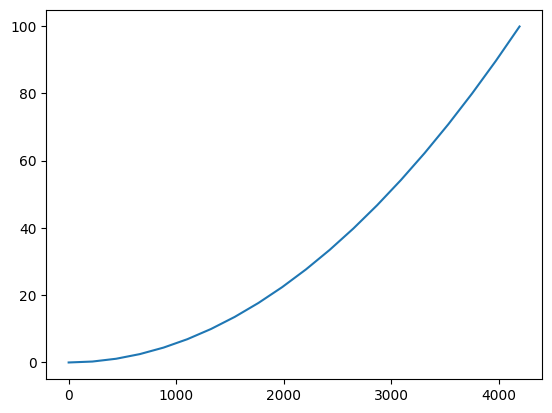

In [67]:
plt.plot(x0, z0)
plt.show()

In [68]:
q0=np.zeros(12*N)

In [69]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [70]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    RET = Ret(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

#     Z0= np.dot(RET, tau_force[:3])
    Z0= tau_force[:3]
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################

    ddx,ddy, ddz = (Z/Ws[0]).T

############################################################


               
#     C0 = np.einsum('ijk,kp->ijp', np.einsum('ijk,ikr->ijr', RET, Π(φ,θ,ψ)), tau_force[3:].reshape(3,1))
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))

    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)

    C = (C1.T + C0.squeeze())

    A0 = Jrho(RET,Jrho0)
    A1 = Π(φ,θ,ψ)
    A=np.einsum('ijk,ikr->ijr', A0, A1)

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = me(φ, θ, ψ, φ, θ, ψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    

    
    H = np.cross(w_e(φ,θ,ψ,dφ,dθ,dψ),np.einsum('ijk,ik->ij', A0, w_e(φ,θ,ψ,dφ,dθ,dψ)))

#############################################
#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=scipy.linalg.lstsq(A[i], C[i] + D[i] + G[i] - H[i] - A[i]@B[i], check_finite=True)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)

#     ddφ, ddθ, ddψ = np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)

    ddφ,ddθ,ddψ = np.linalg.solve(A, C + D + G - H - np.einsum('ijk,ik->ij',A, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [71]:
root_ = root(static_func, q0, method='df-sane')

In [72]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 3.765e+02  3.765e+02 ...  0.000e+00  0.000e+00]
       x: [ 2.245e+03  2.466e+03 ...  0.000e+00  0.000e+00]
     nit: 390
    nfev: 1000
  method: df-sane

In [73]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [74]:
# q0 = root_.x

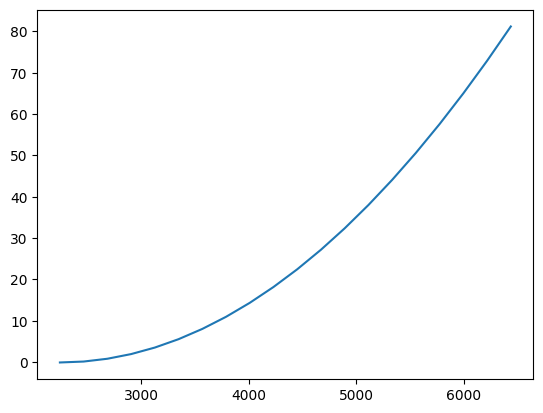

In [75]:
plt.plot(x0_, z0_)
plt.show()